In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def toReal(x):
    if np.iscomplexobj(x):
        return float(np.real(x))


def matrix2real(matrix):
    return np.vectorize(toReal)(matrix)

In [22]:
# 定义流场时间和空间信息
x = np.arange(-8, 8.2, 0.2)  # 81 空间x
y = np.arange(-5, 5.2, 0.2)  # 51 空间y
t = np.arange(0, 6.05, 0.05)  # 121 时间
Fs = 1 / (t[1] - t[0]) # 采样频率
X, Y, T = np.meshgrid(x, y, t)
Ny, Nx, Nt = X.shape
Ny, Nx, Nt

(51, 81, 121)

In [4]:
# 自定义流场，U是沿x方向的速度分量，V是沿y方向的速度分量
U0 = -1 * Y ** 2 + 5
V0 = 0 * Y # UV0不随时间变化，设为定常流场
U1 = -5 * np.sin(Y) * np.cos(2 * np.pi * 0.3 * Y) * np.exp(T / 5)
V1 = 5 * np.sin(X - 1 * np.pi * T) * np.cos(2 * np.pi * 0.3 * Y) * np.exp(T / 5)
U3 = 0.01 * np.random.rand(Ny, Nx, Nt)
V3 = 0.01 * np.random.rand(Ny, Nx, Nt)

U_Sum = U0 + U1 + U3
V_Sum = V0 + V1 + V3

In [25]:
# 计算UV向量
def Uxyt2Uxt(Uxyt):
    # 把3维矩阵的xyt压缩为xt
    Ny, Nx, Nt = Uxyt.shape # 由于meshgrid定义，xy相反
    Nxy = Ny * Nx
    Uxt = np.reshape(Uxyt, (Nxy, Nt))
    return Uxt

def UV2UxyVxy(UVx, Ny, Nx):
    Ux = UVx[0:Ny*Nx]
    Vx = UVx[Ny*Nx::]
    Uxy = np.reshape(Ux, (Ny, Nx))
    Vxy = np.reshape(Vx, (Ny, Nx))
    return Uxy, Vxy

U_xt = Uxyt2Uxt(U_Sum) # 把2维问题转化为1维问题
V_xt = Uxyt2Uxt(V_Sum) # 把2维问题转化为1维问题
# 然后把UV向量合并

UV_xt = np.vstack((U_xt, V_xt))
U_Sum.shape, V_Sum.shape, U_xt.shape, V_xt.shape, UV_xt.shape

((51, 81, 121), (51, 81, 121), (4131, 121), (4131, 121), (8262, 121))

In [6]:
UX = UV_xt[:, 0:UV_xt.shape[1]-1]
UY = UV_xt[:, 1:UV_xt.shape[1]]
UX.shape, UY.shape

((8262, 120), (8262, 120))

In [7]:
def DMD_class(UX, UY):
    # DMD分解函数
    # 输入： X Y DMD分解的数据矩阵
    # 输出： Dd, 特征根
    #        b, 初始状态
    #      Phi, DMD分解的模态
    # Time_DMD, DMD还原信号所用到的时间项
    #   Energy, 每个模态对应的能量，从大到小排序
    N = UX.shape[1]
    # SVD分解
    U, S, VT = scipy.linalg.svd(UX, full_matrices=False)
    # 删除奇异值约等于0的模态，防止计算发散
    Sd = np.diag(S)
    r = np.sum(Sd > 1e-6)
    U = U[:, 0:r]
    S = Sd[0:r, 0:r]
    V = VT.T[:, 0:r]
    # 求解矩阵A
    A = U.T @ (UY @ V @ scipy.linalg.inv(S))
    # 求矩阵A的特征值和特征向量
    D, Om = scipy.linalg.eig(A)
    # 求DMD模态
    Phi = UY @ V @ scipy.linalg.inv(S) @ Om
    # 求解初始状态b
    b, residuals, rank, singular_values = np.linalg.lstsq(Phi, UX[:, 0], rcond=None)

    Dd = np.diag(D)

    # 计算范德蒙矩阵
    Q = np.vander(D, N, increasing=True)
    Time_DMD = b.reshape(len(b), 1) * Q

    Energy = np.zeros(np.size(Phi, 1))
    for i in range(np.size(Phi, 1)):
        Uxt_DMD_k = np.real(Phi[:, i].reshape((Phi.shape[0], 1)) * Time_DMD[i, :].reshape((1, Time_DMD.shape[1])))
        E_k = np.sum((Uxt_DMD_k ** 2))
        Energy[i] = E_k

    # 对于每个模态的能量进行排序
    Ie = np.argsort(-Energy)
    Energy = Energy[Ie]
    Dd = Dd[Ie]
    b = b[Ie]
    Phi = Phi[:, Ie]
    Time_DMD = Time_DMD[Ie, :]
    
    return Dd,b,Phi,Time_DMD,Energy

In [8]:
# 计算DMD
Dd, b, Phi, Time_DMD, Energy = DMD_class(UX, UY) 

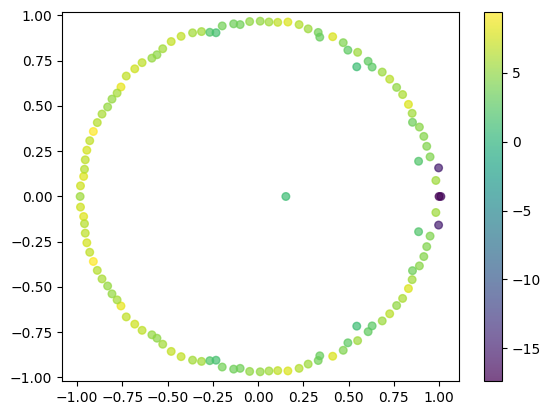

In [9]:
fig = plt.figure(1)
# 图1 输出特征根分布
plt.scatter(np.sum(np.real(Dd[::-1]), axis=1),
            np.sum(np.imag(Dd[::-1]), axis=1),
            s=30,
            c=-np.log(Energy[::-1]),
            cmap='viridis',
            alpha=0.7)
plt.colorbar()
plt.axis('equal')
plt.show()

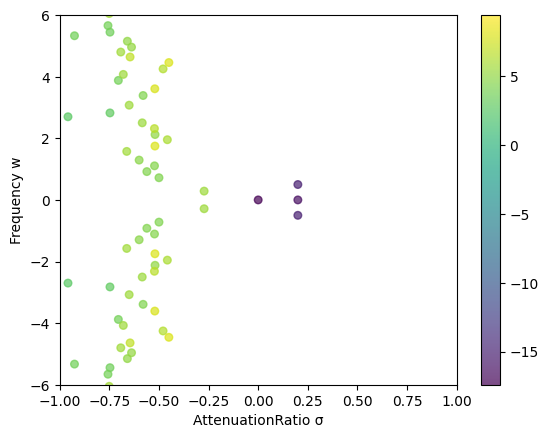

In [10]:
fig2 = plt.figure(2)
# 图2 绘制频率和衰减图
wa = np.log(np.sum(Dd, axis=1)) * Fs
# 增加一个极小的数防止计算过程出现inf
plt.scatter(np.real(wa),
            np.imag(wa) / (2 * np.pi),
            s=30,
            c=-np.log(Energy),
            cmap='viridis',
            alpha=0.7)
plt.xlabel('AttenuationRatio σ')
plt.ylabel('Frequency w')
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-6, 6)
plt.show()

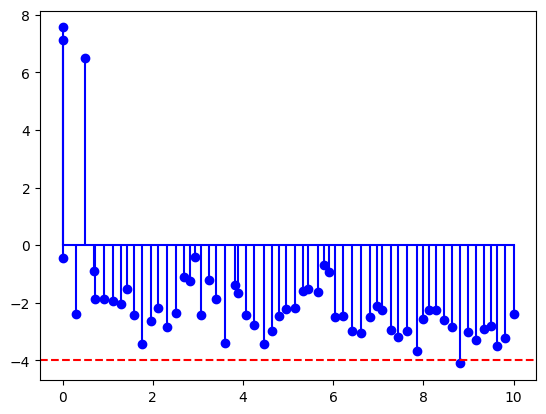

In [11]:
fig3 = plt.figure(3)
# 频率-能量排序
Freq = np.imag(wa) / 2 / np.pi
# 找到大于等于0的频率部分的索引
k = np.where(Freq >= 0)[0]

# 绘制幅度谱
plt.stem(Freq[k], np.log10(Energy[k]), basefmt='b', linefmt='b-', 
         markerfmt='bo')

# 设置基线值为-6
plt.axhline(y=-4, color='r', linestyle='--')

# 显示图形
plt.show()

<BarContainer object of 10 artists>

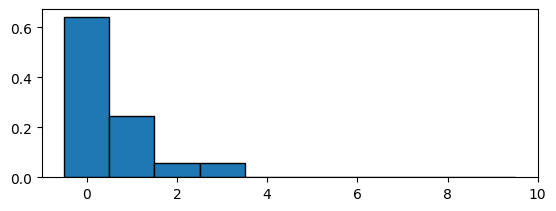

In [12]:
fig5 = plt.figure(5)
plt.subplot(2, 1, 1)
E_bar = Energy / np.sum(Energy)
plt.bar(np.arange(0, 10), E_bar[:10], width=1, edgecolor='black')

In [13]:
def curl(Uxy0, Vxy0, X, Y):

    return (np.gradient(Uxy0, axis=0) / 80 + np.gradient(Vxy0, axis=1) / 50)

In [23]:
X.shape


(51, 81, 121)

Text(0.5, 1.0, 'Third & Fourth Mode')

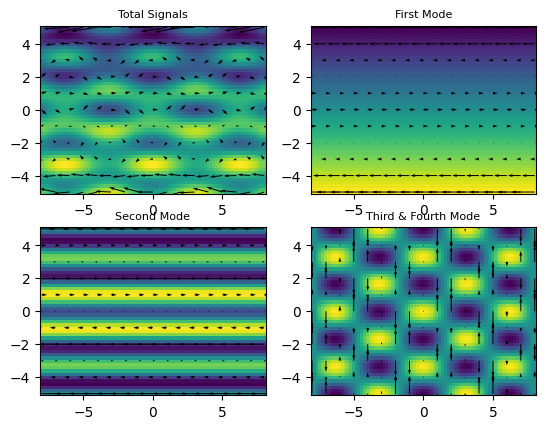

In [33]:
# 绘制模态
Xgrid = X[:, :, 0]
Ygrid = Y[:, :, 0]

k = 0
fig6 = plt.figure(6)
plt.subplot(2, 2, 1) # 总信号
Uxy0, Vxy0 = UV2UxyVxy(UV_xt[:, k], Ny, Nx)
plt.pcolor(Xgrid, Ygrid, curl(Uxy0, Vxy0, Xgrid, Ygrid))
plt.quiver(Xgrid[::5, ::5],
           Ygrid[::5, ::5],
           Uxy0[::5, ::5],
           Vxy0[::5, ::5],
           color="k")
plt.title("Total Signals", fontsize=8)


plt.subplot(2, 2, 2) # 1阶
Uxt_DMD_1 = np.real(np.outer(Phi[:, 0], Time_DMD[0, :]))
Uxyk, Vxyk = UV2UxyVxy(Uxt_DMD_1[:, k], Ny, Nx)
plt.pcolor(Xgrid, Ygrid, curl(Uxyk, Vxyk, Xgrid, Ygrid))
plt.quiver(Xgrid[::5, ::5],
           Ygrid[::5, ::5],
           Uxyk[::5, ::5],
           Vxyk[::5, ::5],
           color="k")
plt.title("First Mode", fontsize=8)

plt.subplot(2, 2, 3) # 2阶
Uxt_DMD_2 = np.real(np.outer(Phi[:, 1], Time_DMD[1, :]))
Uxyk, Vxyk = UV2UxyVxy(Uxt_DMD_2[:, k], Ny, Nx)
plt.pcolor(Xgrid, Ygrid, curl(Uxyk, Vxyk, Xgrid, Ygrid))
plt.quiver(Xgrid[::5, ::5],
           Ygrid[::5, ::5],
           Uxyk[::5, ::5],
           Vxyk[::5, ::5],
           color="k")
plt.title("Second Mode", fontsize=8)

plt.subplot(2, 2, 4) # 3+4阶
Uxt_DMD_3 = np.real(np.outer(Phi[:, 2], Time_DMD[2, :]))
Uxy3, Vxy3 = UV2UxyVxy(Uxt_DMD_3[:, k], Ny, Nx)
Uxt_DMD_4 = np.real(np.outer(Phi[:, 3], Time_DMD[3, :]))
Uxy4, Vxy4 = UV2UxyVxy(Uxt_DMD_4[:, k], Ny, Nx)
Uxyk = Uxy3 + Uxy4
Vxyk = Vxy3 + Vxy4
plt.pcolor(Xgrid, Ygrid, curl(Uxyk, Vxyk, Xgrid, Ygrid))
plt.quiver(Xgrid[::5, ::5],
           Ygrid[::5, ::5],
           Uxyk[::5, ::5],
           Vxyk[::5, ::5],
           color="k")
plt.title("Third & Fourth Mode", fontsize=8)